In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

print('Tensorflow version: {}'.format(tf.__version__))

2024-05-28 11:50:44.839678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 11:50:44.839857: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 11:50:44.841699: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-28 11:50:44.864339: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 11:50:45.329586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Tensorflow version: 2.16.1


### Data Preprocessing - Single Stock

In [17]:
# Load and prepare the dataset
file_path = 'target.csv'  # Make sure to have your dataset ready
df = pd.read_csv(file_path)
data = df[['close']].values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Parameters
time_step = 30
training_size = int(len(data_scaled) * 0.7)
test_size = len(data_scaled) - training_size
train_data, test_data = data_scaled[0:training_size,:], data_scaled[training_size:len(data_scaled),:]

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (1449, 100, 1)
y_train shape: (1449,)
X_test shape: (564, 100, 1)
y_test shape: (564,)


### Data Preprocessing - Multiple Stocks

In [4]:
# Version 2

# 讀取合併後的數據
file_path = './combined_10_stock_prices_datetime_2010-2023.csv'
df = pd.read_csv(file_path)

# 創建數據集並按8:1:1的比例切分
def create_and_split_dataset(df, time_step=30):
    trainX, trainY, valX, valY, testX, testY = [], [], [], [], [], []
    scalers = {}
    for stock in df['ticker'].unique():
        stock_data = df[df['ticker'] == stock].copy()
        data = stock_data[['close']].values
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(data)
        scalers[stock] = scaler  # 保存每支股票的標準化器
        
        x, y = [], []
        for i in range(len(data_scaled) - time_step - 1):
            a = data_scaled[i:(i + time_step), :]
            x.append(a)
            y.append(data_scaled[i + time_step, -1])  # 第time_step+1天的'close'價格作為目標
        
        x, y = np.array(x), np.array(y)
        
        train_size = int(len(x) * 0.8)
        val_size = int(len(x) * 0.1)
        
        trainX.extend(x[:train_size])
        trainY.extend(y[:train_size])
        valX.extend(x[train_size:train_size + val_size])
        valY.extend(y[train_size:train_size + val_size])
        testX.extend(x[train_size + val_size:])
        testY.extend(y[train_size + val_size:])
    
    return (np.array(trainX), np.array(trainY),
            np.array(valX), np.array(valY),
            np.array(testX), np.array(testY),
            scalers)

# 創建標準化器
scaler = MinMaxScaler(feature_range=(0, 1))

# 創建數據集函數
def create_dataset(stock_data, time_step=30):
    dataX, dataY = [], []
    data = stock_data[['close']].values
    data_scaled = scaler.fit_transform(data)
    for i in range(len(data_scaled) - time_step - 1):
        a = data_scaled[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(data_scaled[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30

# 創建並切分數據集
x_train, y_train, x_val, y_val, x_test, y_test, scalers = create_and_split_dataset(df, time_step)

# 調整輸入形狀以符合模型需求
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])

print(f"x_train.shape: {x_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"x_val.shape: {x_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"x_test.shape: {x_test.shape}")
print(f"y_test.shape: {y_test.shape}")


x_train.shape: (27180, 30, 1)
y_train.shape: (27180,)
x_val.shape: (3390, 30, 1)
y_val.shape: (3390,)
x_test.shape: (3410, 30, 1)
y_test.shape: (3410,)


### Transformer Block

In [5]:
# Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

###  Model Definition

In [6]:
# Model Definition
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.1)
x = GlobalAveragePooling1D(data_format='channels_first')(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1, activation="linear")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 1)     │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 4)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 1)     │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 1)     │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 30)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30)        │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 20)        │        620 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         21 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,827 (30.57 KB)

 Trainable params: 7,827 (30.57 KB)

 Non-trainable params: 0 (0.00 B)

### Model Training

In [7]:
# Train the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

from keras.callbacks import EarlyStopping


history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_val, y_val),
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0102 - val_loss: 0.0047
Epoch 2/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 3/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 4/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 5/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 6/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.5086e-04 - val_loss: 0.0030
Epoch 7/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 8.4110e-04 - val_loss: 0.0048
Epoch 8/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 7.2785e-04 - val_loss: 0.0035
Epoch 9/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.5470e-04 - val_loss: 0.0044
Epoch 10/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.3017e-04 - val_loss: 0.0031
Epoch 11/200
425/425 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.3933e-04 - val_loss: 0.0047
Epoch 12/200
425/

### Model Performance
compute RMSE of model

In [8]:
def inverse_transform(scalers, data, tickers, original_shape):
    result = []
    for i in range(len(data)):
        ticker = tickers[i]
        scaler = scalers[ticker]
        # 構建與原始數據形狀一致的數據，用零填充其他列
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])  # 取出反標準化後的close值
    return np.array(result)

# 生成對應的tickers列表，確保每個列表的長度與對應數據集長度一致
train_tickers = []
val_tickers = []
test_tickers = []

for stock in df['ticker'].unique():
    stock_data = df[df['ticker'] == stock]
    x, y = create_dataset(stock_data, time_step)
    train_size = int(len(x) * 0.8)
    val_size = int(len(x) * 0.1)
    test_size = len(x) - train_size - val_size

    train_tickers.extend([stock] * train_size)
    val_tickers.extend([stock] * val_size)
    test_tickers.extend([stock] * test_size)

train_tickers = np.array(train_tickers)
val_tickers = np.array(val_tickers)
test_tickers = np.array(test_tickers)

# Make predictions
train_predict = model.predict(x_train)
val_predict = model.predict(x_val)
test_predict = model.predict(x_test)

# Inverse transform predictions and true values
original_shape = x_train.shape[2]  # 獲取原始數據的特徵數量
train_predict = inverse_transform(scalers, train_predict, train_tickers, original_shape)
val_predict = inverse_transform(scalers, val_predict, val_tickers, original_shape)
test_predict = inverse_transform(scalers, test_predict, test_tickers, original_shape)

y_train_true = inverse_transform(scalers, y_train.reshape(-1, 1), train_tickers, original_shape)
y_val_true = inverse_transform(scalers, y_val.reshape(-1, 1), val_tickers, original_shape)
y_test_true = inverse_transform(scalers, y_test.reshape(-1, 1), test_tickers, original_shape)

# Evaluate the model (Calculate RMSE or other metrics)
train_rmse = math.sqrt(mean_squared_error(y_train_true, train_predict))
val_rmse = math.sqrt(mean_squared_error(y_val_true, val_predict))
test_rmse = math.sqrt(mean_squared_error(y_test_true, test_predict))

print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Test RMSE: {test_rmse}")


850/850 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train RMSE: 59.29979738308291
Validation RMSE: 38.51468617007537
Test RMSE: 32.62227562428178


### Model Performance
predict on testing set and illustrate a chart

107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


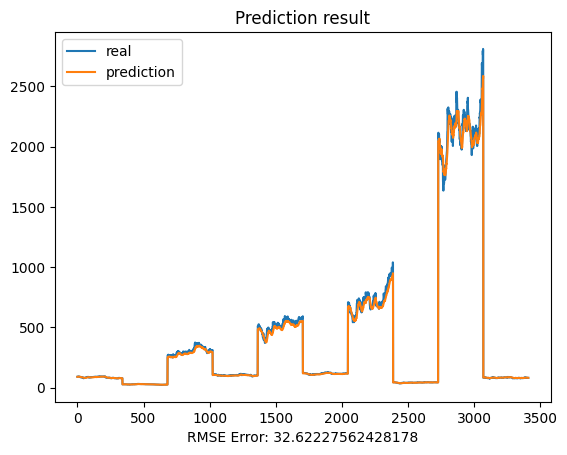

In [9]:
# Make predictions
test_predict = model.predict(x_test)

original_shape = x_train.shape[2]  # 獲取原始數據的特徵數量

# Inverse transform true values and predictions
test_predict = inverse_transform(scalers, test_predict, test_tickers, original_shape)
y_test_true = inverse_transform(scalers, y_test.reshape(-1, 1), test_tickers, original_shape)

# Plot the results
plt.figure(1)
plt.plot(y_test_true, label='real')
plt.plot(test_predict, label='prediction')

# Calculate and display RMSE
rmse = np.sqrt(mean_squared_error(y_test_true, test_predict))
plt.xlabel('RMSE Error: {}'.format(rmse))
plt.legend()
plt.title('Prediction result')
plt.show()

### Save model as weight file

In [10]:
model.save('1-feature_model.keras')

# Models comparison - TSMC testing set evaluation
### Fetch target stock price history data

In [14]:
import yfinance as yf

# 抓取台積電的歷史股價資料
stock = '2330.TW'
stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
stock_data = stock_data.reset_index()
stock_data = stock_data[['Date', 'High', 'Low', 'Open', 'Close']]
stock_data.columns = ['date', 'high', 'low', 'open', 'close']
stock_data['ticker'] = stock  # 添加一列來標識股票
print(stock_data.head())

[*********************100%%**********************]  1 of 1 completed

        date       high        low       open      close   ticker
0 2010-01-04  65.000000  64.000000  65.000000  64.900002  2330.TW
1 2010-01-05  65.099998  63.900002  65.000000  64.500000  2330.TW
2 2010-01-06  64.900002  63.700001  64.500000  64.900002  2330.TW
3 2010-01-07  65.000000  64.199997  64.900002  64.199997  2330.TW
4 2010-01-08  64.300003  63.500000  63.500000  64.000000  2330.TW


### Data Preprocessing

In [15]:
# 標準化數據
scaler = MinMaxScaler(feature_range=(0, 1))
data = stock_data[['close']].values
data_scaled = scaler.fit_transform(data)

# 創建數據集
def create_single_stock_dataset(data_scaled, time_step=30):
    dataX, dataY = [], []
    for i in range(len(data_scaled) - time_step - 1):
        a = data_scaled[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(data_scaled[i + time_step, -1])  # 使用'close'作為目標變量
    return np.array(dataX), np.array(dataY)

# 參數
time_step = 30
x_stock, y_stock = create_single_stock_dataset(data_scaled, time_step)

# 調整輸入形狀以符合模型需求
x_stock = x_stock.reshape(x_stock.shape[0], x_stock.shape[1], x_stock.shape[2])

# 劃分訓練集和測試集
train_size = int(len(x_stock) * 0.8)
val_size = int(len(x_stock) * 0.1)
x_stock_train, x_stock_val, x_stock_test = x_stock[:train_size], x_stock[train_size:train_size+val_size], x_stock[train_size+val_size:]
y_stock_train, y_stock_val, y_stock_test = y_stock[:train_size], y_stock[train_size:train_size+val_size], y_stock[train_size+val_size:]
# x_stock_train, x_stock_test = x_stock[:train_size], x_stock[train_size:]
# y_stock_train, y_stock_test = y_stock[:train_size], y_stock[train_size:]

print('x_stock_train shape: {}'.format(x_stock_train.shape))
print('y_stock_train shape: {}'.format(y_stock_train.shape))
print('x_stock_val shape: {}'.format(x_stock_val.shape))
print('y_stock_val shape: {}'.format(y_stock_val.shape))
print('x_stock_test shape: {}'.format(x_stock_test.shape))
print('y_stock_test shape: {}'.format(y_stock_test.shape))

x_stock_train shape: (2718, 30, 1)
y_stock_train shape: (2718,)
x_stock_val shape: (339, 30, 1)
y_stock_val shape: (339,)
x_stock_test shape: (341, 30, 1)
y_stock_test shape: (341,)


### Model Performance

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fine-tuned RMSE: 30.302006894867326


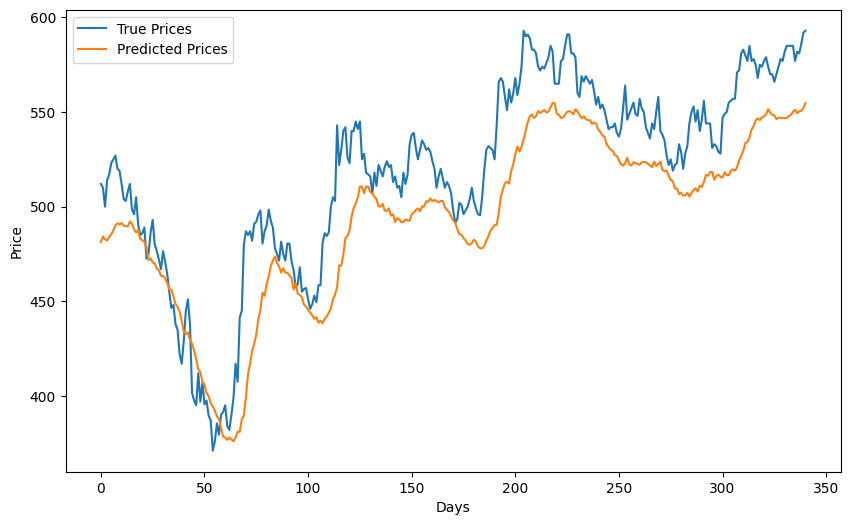

In [16]:
# 微調前的模型預測表現
predicted_stock_prices = model.predict(x_stock_test)

# 反標準化預測值
def inverse_transform(scaler, data, original_shape):
    result = []
    for i in range(len(data)):
        scaled_data = np.concatenate([np.zeros((1, original_shape - 1)), data[i].reshape(1, -1)], axis=1)
        result.append(scaler.inverse_transform(scaled_data)[0, -1])
    return np.array(result)

predicted_stock_prices = inverse_transform(scaler, predicted_stock_prices, original_shape=x_stock.shape[2])
y_stock_test_true = inverse_transform(scaler, y_stock_test.reshape(-1, 1), original_shape=x_stock.shape[2])

# 計算微調後的RMSE
fine_tune_rmse = math.sqrt(mean_squared_error(y_stock_test_true, predicted_stock_prices))

print(f"Fine-tuned RMSE: {fine_tune_rmse}")

# 畫出預測結果
plt.figure(figsize=(10, 6))
plt.plot(y_stock_test_true, label='True Prices')
plt.plot(predicted_stock_prices, label='Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
